# Clustering

## Settings

In [57]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Esophagus'

In [58]:
# set true if you want rerun umap embedding
run_umap = True
n_pcs = None

##################### CLUSTERING ########################
# clustering method
method = 'leiden'  # leiden or louvain
n_neighbors=15 #Set the number of nearest neighbors to be used in clustering. Default=15
# if True, a range of resolutions will be calculated and plotted, so you can choose the best fit
# If False, set the resolution parameter
search_clustering_parameters = True
res = 0.5

# name of condition column in adata.obs, will be used for plotting
condition_column = 'sample'

# save figures
save_figs = False

## Loading packages and setup

In [59]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
import sctoolbox.plotting as pl
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [60]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [61]:
norm_correction_output = tree.norm_correction_anndata 
adata = epi.read_h5ad(norm_correction_output)
adata

AnnData object with n_obs × n_vars = 11552 × 139599
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'highly_variable'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'connectivities', 'distances'

## PCA

In [62]:
# maybe run PCA again after batch correction?
#sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

### Subset number of PCs
 Find initial neighbors and calculate differential expression
- NOTE: trim: Set to 0 to skip default 10. trims neighbours of cells can help to identify individual populations. Lower value more population but more batch
- NOTE: n_pcs: number of pca dimensions

In [63]:
if n_pcs is None:
    n_pcs = analyser.define_PC(adata)

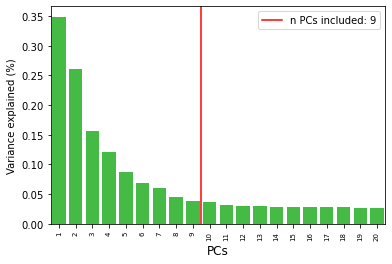

In [64]:
ax = pl.plot_pca_variance(adata)
ax.axvline(n_pcs-0.5, color="red", label=f"n PCs included: {n_pcs}")
plt.legend()
#utils.save_figure(figure_path + "PC_selection.pdf")

In [65]:
# Subset PCA
analyser.subset_PCA(adata, n_pcs, start=0)

## Calc Neighbours

In [66]:
# do we have to run neighbors again after batch correction?
# # Change to module
# if save_figs:
#     epi.pl.pca_overview(adata, color=['nb_features'], show=False)
#     #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
#     plt.show()
# else:
#     epi.pl.pca_overview(adata, color=['nb_features'])

In [67]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

## UMAP

Computing UMAPs:   0%|          | 0/8 [00:00<?, ?it/s]

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


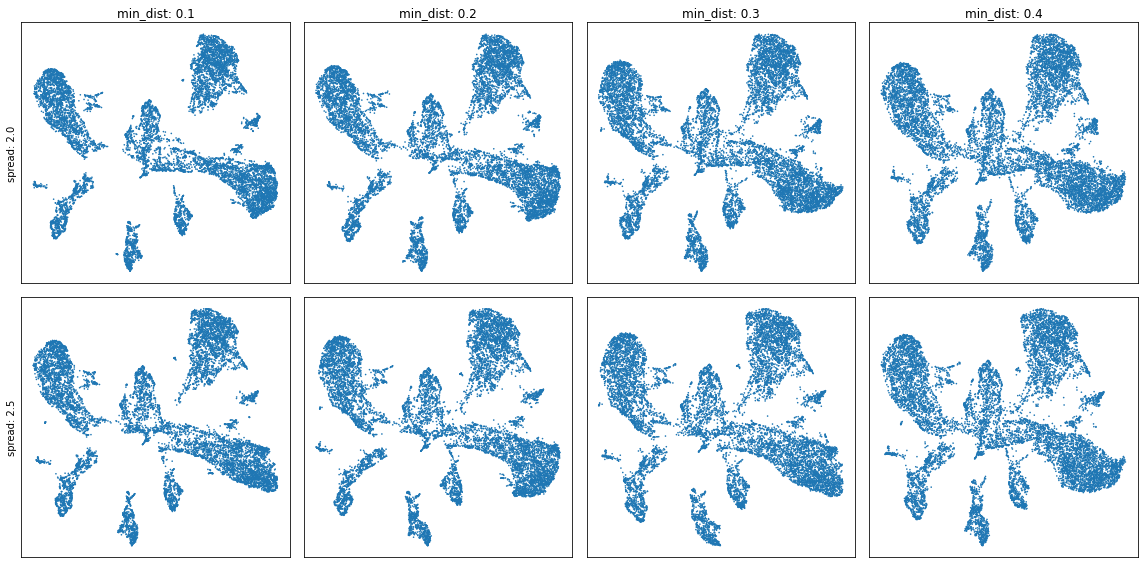

In [68]:
if run_umap:
    pl.search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol='sample', 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

Input min_dist parameter: 0.1
Input spread parameter: 2.0


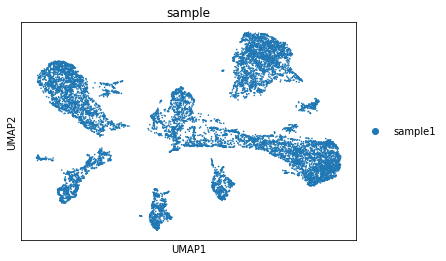

In [69]:
if run_umap:
    min_dist = float(input('Input min_dist parameter: '))
    spread = float(input('Input spread parameter: '))
    # Plot final UMAP with quality measures
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    sc.pl.umap(adata, color=condition_column)

## Cell Clustering
- NOTE: resolution: controls the coarseness of the clustering. Higher values lead to more clusters.

Plotting umap for resolution=0.1 (1 / 9)
Plotting umap for resolution=0.2 (2 / 9)
Plotting umap for resolution=0.3 (3 / 9)
Plotting umap for resolution=0.4 (4 / 9)
Plotting umap for resolution=0.5 (5 / 9)
Plotting umap for resolution=0.6 (6 / 9)
Plotting umap for resolution=0.7 (7 / 9)
Plotting umap for resolution=0.8 (8 / 9)
Plotting umap for resolution=0.9 (9 / 9)


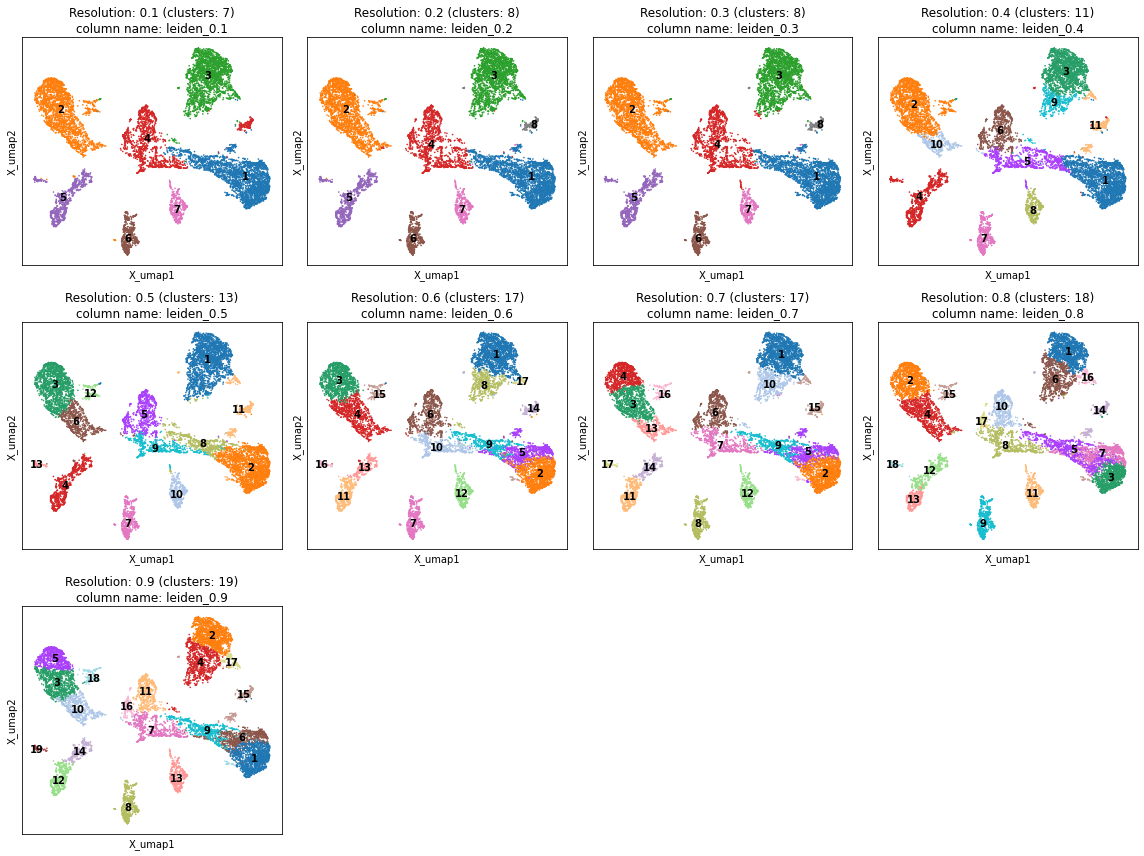

In [70]:
# plot different clustering resolutions
if search_clustering_parameters:
    pl.search_clustering_parameters(adata, ncols=4, method=method)

In [71]:
# choose final resolution
if search_clustering_parameters:
    res = input('Input resolution for final clustering: ')
    clustering_column = "leiden_" + res

Input resolution for final clustering: 0.1


### Reclustering
- Based on the last two plots, mainly the heatmap, decide how to make reclusterization.

In [72]:
recluster_dec = input('Do you want to recluster? answer with yes or no: ')

Do you want to recluster? answer with yes or no: no


In [73]:
if recluster_dec.lower() == 'yes':
    recluster_cols = input('Which clusters do you want to recluster? Enter cluster numbers sperated by commas: ')
    recluster_cols = recluster_cols.split(',')
    join_split = input("Do you want to join or split the clusters? ")
    recluster(adata, clustering_column, recluster_cols, task=join_split)
    clustering_column += "_recluster"  #update clustering column

In [74]:
#Create final clustering
adata.obs["clustering"] = analyser.rename_categories(adata.obs[clustering_column])

### Final clustering

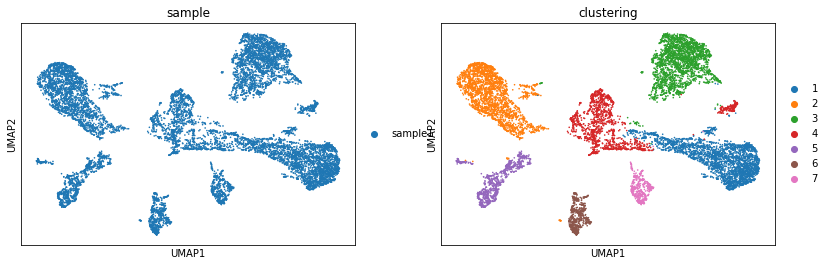

In [75]:
#Plot final leiden
sc.pl.umap(adata, color=[condition_column, "clustering"])
#utils.save_figure(figure_path + "umap_final.pdf")

## Plot distribution of cells across clusters

In [76]:
n_cells_barplot(adata, "clustering", groupby=condition_column)
#                    save=figure_path + "cell_distribution_barplot.pdf")


NameError: name 'n_cells_barplot' is not defined

## save anndata

In [77]:
adata_output = tree.clustering_anndata
adata.write(filename=adata_output)